In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import os
from PIL import Image
import sys
import matplotlib.pyplot as plt

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
# Copy dataset from Google Drive to Colab local storage for faster access
!cp -r "/content/drive/MyDrive/dataset" "/content/dataset"

# Define paths for training and validation datasets
train_dir = '/content/dataset/train'
validation_dir = '/content/dataset/validation'

cp: cannot create symbolic link '/content/dataset/dataset': Read-only file system


In [5]:
def is_valid_image(filepath):
    """
    Check if the given file is a valid image.
    Args:
        filepath (str): Path to the image file.
    Returns:
        bool: True if the image is valid, False otherwise.
    """
    try:
        # Attempt to open the image file and verify its integrity
        with Image.open(filepath) as img:
            img.verify()
        return True
    except:
        # Print an error message to stderr if the image is corrupted
        print(f"Corrupted Image Found: {filepath}", file=sys.stderr)
        return False

class FilteredImageFolder(datasets.ImageFolder):
    """
    Custom ImageFolder class that filters out corrupted images.
    Args:
        root (str): Root directory path.
        transform (callable, optional): A function/transform to apply to the images.
    """
    def __init__(self, root, transform=None):
        # Initialize the parent class
        super(FilteredImageFolder, self).__init__(root=root, transform=transform)

        # List to store valid images
        valid_images = []

        # Iterate through all images and filter out corrupted ones
        for item in self.imgs:
            if is_valid_image(item[0]):  # Check if the image is valid
                valid_images.append(item)

        # Update the imgs and samples attributes with only valid images
        self.imgs = valid_images
        self.samples = valid_images

### Data Augmentation

Data augmentation is a technique used to artificially expand the size of a dataset by applying various transformations to the existing data. In the context of image processing, augmentation helps improve the robustness and generalization of machine learning models by introducing variations in the training data. This is especially useful when the dataset is small or imbalanced.

Common image augmentation techniques include:

- **Flipping**: Horizontally or vertically flipping the image.
- **Rotation**: Rotating the image by a certain angle.
- **Scaling**: Zooming in or out of the image.
- **Cropping**: Randomly cropping a portion of the image.
- **Translation**: Shifting the image along the x or y axis.
- **Color Jittering**: Adjusting brightness, contrast, saturation, or hue.
- **Gaussian Noise**: Adding random noise to the image.
- **Normalization**: Scaling pixel values to a specific range.

In PyTorch, the `torchvision.transforms` module provides a variety of augmentation techniques that can be applied to datasets.

In [6]:
# Define image dimensions
img_width, img_height = 150, 150

# Define batch size and number of epochs for training
batch_size = 32
num_epochs = 20

# Define transformations for the training dataset
train_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),  # Resize images to the specified dimensions
    transforms.RandomRotation(40),  # Randomly rotate images by up to 40 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomAffine(0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),  # Apply random affine transformations
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images using mean and std
])

# Define transformations for the validation dataset
val_transforms = transforms.Compose([
    transforms.Resize((img_width, img_height)),  # Resize images to the specified dimensions
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images using mean and std
])

In [ ]:
# Print a message indicating the training dataset is being loaded and validated
print("Loading and Validating training dataset...")

# Load the training dataset using the custom FilteredImageFolder class
# This will filter out corrupted images and apply the defined transformations
train_dataset = FilteredImageFolder(
    root='dataset/train',  # Path to the training dataset
    transform=train_transform  # Transformations to apply to the training images
)

# Print a message indicating the validation dataset is being loaded and validated
print("Loading and validating validation dataset...")

# Load the validation dataset using the custom FilteredImageFolder class
# This will filter out corrupted images and apply the defined transformations
val_dataset = FilteredImageFolder(
    root='dataset/validation',  # Path to the validation dataset
    transform=val_transforms  # Transformations to apply to the validation images
)

# Print the classes (categories) present in the training and validation datasets
print("Training classes:", train_dataset.classes)
print("Validation classes:", val_dataset.classes)

Loading and Validating training dataset...


Corrupted Image Found: dataset/train/dogs/11702.jpg
/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Loading and validating validation dataset...
Training classes: ['cats', 'dogs']
Validation classes: ['cats', 'dogs']


In [ ]:
# Create a DataLoader for the training dataset
# - `train_dataset`: The dataset to load
# - `batch_size`: Number of samples per batch
# - `shuffle`: Shuffle the data at every epoch
# - `num_workers`: Number of subprocesses to use for data loading
# - `pin_memory`: If True, the data loader will copy tensors into CUDA pinned memory
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# Building CNN

In [9]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()

        # Define the feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3),  # Convolutional layer with 32 filters and 3x3 kernel size
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(2, 2),  # Max pooling with 2x2 kernel size and stride 2

            nn.Conv2d(32, 64, 3),  # Convolutional layer with 64 filters
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(2, 2),  # Max pooling

            nn.Conv2d(64, 128, 3),  # Convolutional layer with 128 filters
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(2, 2),  # Max pooling

            nn.Conv2d(128, 128, 3),  # Another convolutional layer with 128 filters
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(2, 2)  # Max pooling
        )

        # Adaptive average pooling to reduce spatial dimensions to 1x1
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Define the classifier layers
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Flatten the feature map into a vector
            nn.Linear(128, 512),  # Fully connected layer with 512 units
            nn.ReLU(),  # Activation function
            nn.Linear(512, num_classes)  # Output layer with 'num_classes' units
        )

    def forward(self, x):
        # Pass input through feature extraction layers
        x = self.features(x)
        # Apply adaptive average pooling
        x = self.avg_pool(x)
        # Pass through the classifier layers
        x = self.classifier(x)
        return x

In [10]:
model = CNNClassifier(num_classes= len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Parameters: {count_parameters(model):,}")


Model Parameters: 307,906


In [11]:
train_losses = []  # List to store training losses for each epoch
val_losses = []  # List to store validation losses for each epoch

# Modified training loop to track losses and save the best model
best_val_acc = 0.0  # Variable to track the best validation accuracy

for epoch in range(num_epochs):
    print(f'\nEpoch [{epoch+1}/{num_epochs}]')  # Print the current epoch

    # Training phase
    model.train()  # Set the model to training mode
    train_loss = 0.0  # Initialize training loss for the epoch
    train_correct = 0  # Initialize count of correctly classified training samples
    train_total = 0  # Initialize total training samples

    # Progress bar for training
    pbar = tqdm(total=len(train_loader), desc=f'Training')
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)  # Load inputs and labels

        optimizer.zero_grad()  # Clear gradients from the previous step
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass (compute gradients)

        # Track gradient norms for debugging or analysis
        grad_norms = {}
        for name, param in model.named_parameters():
            if param.grad is not None:
                grad_norms[name] = param.grad.norm().item()

        optimizer.step()  # Update model parameters

        # Update training metrics
        train_loss += loss.item()
        _, predicted = outputs.max(1)  # Get predicted class
        train_total += labels.size(0)  # Update total samples
        train_correct += predicted.eq(labels).sum().item()  # Update correct predictions

        # Update progress bar with average loss and accuracy
        avg_loss = train_loss / (i + 1)
        acc = 100. * train_correct / train_total
        pbar.set_description(f'Train | Loss: {avg_loss:.4f} | Acc: {acc:.2f}%')
        pbar.update(1)

    pbar.close()  # Close the progress bar

    # Store average training loss for the epoch
    train_losses.append(train_loss / len(train_loader))

    # Print gradient norms for debugging
    print("\nGradient Norms:")
    for name, norm in grad_norms.items():
        print(f"{name}: {norm:.4f}")

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize validation loss for the epoch
    val_correct = 0  # Initialize count of correctly classified validation samples
    val_total = 0  # Initialize total validation samples

    # Progress bar for validation
    pbar = tqdm(total=len(val_loader), desc=f'Validation')
    with torch.no_grad():  # Disable gradient computation for validation
        for i, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)  # Load inputs and labels
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            # Update validation metrics
            val_loss += loss.item()
            _, predicted = outputs.max(1)  # Get predicted class
            val_total += labels.size(0)  # Update total samples
            val_correct += predicted.eq(labels).sum().item()  # Update correct predictions

            # Update progress bar with average loss and accuracy
            avg_loss = val_loss / (i + 1)
            acc = 100. * val_correct / val_total
            pbar.set_description(f'Val | Loss: {avg_loss:.4f} | Acc: {acc:.2f}%')
            pbar.update(1)

    pbar.close()  # Close the progress bar

    # Store average validation loss for the epoch
    val_losses.append(val_loss / len(val_loader))

    # Calculate training and validation accuracy
    train_acc = 100. * train_correct / train_total
    val_acc = 100. * val_correct / val_total

    # Print epoch summary
    print(f'\nEpoch Summary:')
    print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')

    # Save the model if validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc  # Update best validation accuracy
        torch.save(model.state_dict(), 'catsanddogs_classifier.pth')  # Save model state
        print(f'New best model saved! (Validation Accuracy: {val_acc:.2f}%)')



Epoch [1/20]


Training:   0%|          | 0/298 [00:00<?, ?it/s]


Gradient Norms:
features.0.weight: 0.7041
features.0.bias: 0.1356
features.3.weight: 0.6331
features.3.bias: 0.1218
features.6.weight: 0.4181
features.6.bias: 0.1822
features.9.weight: 0.1067
features.9.bias: 0.0836
classifier.1.weight: 0.0931
classifier.1.bias: 0.1013
classifier.3.weight: 0.2021
classifier.3.bias: 0.2130


Validation:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch Summary:
Train Loss: 0.6681, Train Acc: 58.17%
Val Loss: 0.6426, Val Acc: 59.93%
New best model saved! (Validation Accuracy: 59.93%)

Epoch [2/20]


Training:   0%|          | 0/298 [00:00<?, ?it/s]


Gradient Norms:
features.0.weight: 0.6605
features.0.bias: 0.0978
features.3.weight: 0.4320
features.3.bias: 0.0590
features.6.weight: 0.2110
features.6.bias: 0.0660
features.9.weight: 0.0696
features.9.bias: 0.0217
classifier.1.weight: 0.0599
classifier.1.bias: 0.0337
classifier.3.weight: 0.1157
classifier.3.bias: 0.0623


Validation:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch Summary:
Train Loss: 0.6417, Train Acc: 63.24%
Val Loss: 0.6131, Val Acc: 66.60%
New best model saved! (Validation Accuracy: 66.60%)

Epoch [3/20]


Training:   0%|          | 0/298 [00:00<?, ?it/s]


Gradient Norms:
features.0.weight: 0.9015
features.0.bias: 0.2148
features.3.weight: 0.7981
features.3.bias: 0.1323
features.6.weight: 0.4207
features.6.bias: 0.2621
features.9.weight: 0.0860
features.9.bias: 0.0711
classifier.1.weight: 0.1123
classifier.1.bias: 0.0939
classifier.3.weight: 0.2313
classifier.3.bias: 0.2111


Validation:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch Summary:
Train Loss: 0.6248, Train Acc: 65.10%
Val Loss: 0.5872, Val Acc: 68.65%
New best model saved! (Validation Accuracy: 68.65%)

Epoch [4/20]


Training:   0%|          | 0/298 [00:00<?, ?it/s]


Gradient Norms:
features.0.weight: 2.1434
features.0.bias: 0.4025
features.3.weight: 0.6063
features.3.bias: 0.1916
features.6.weight: 0.1768
features.6.bias: 0.0747
features.9.weight: 0.0323
features.9.bias: 0.0281
classifier.1.weight: 0.0311
classifier.1.bias: 0.0417
classifier.3.weight: 0.0667
classifier.3.bias: 0.0276


Validation:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch Summary:
Train Loss: 0.6091, Train Acc: 66.97%
Val Loss: 0.5919, Val Acc: 68.55%

Epoch [5/20]


Training:   0%|          | 0/298 [00:00<?, ?it/s]


Gradient Norms:
features.0.weight: 1.0321
features.0.bias: 0.2645
features.3.weight: 0.5331
features.3.bias: 0.1421
features.6.weight: 0.3238
features.6.bias: 0.1653
features.9.weight: 0.0581
features.9.bias: 0.0991
classifier.1.weight: 0.0422
classifier.1.bias: 0.0780
classifier.3.weight: 0.0638
classifier.3.bias: 0.0042


Validation:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch Summary:
Train Loss: 0.6006, Train Acc: 67.69%
Val Loss: 0.5733, Val Acc: 69.85%
New best model saved! (Validation Accuracy: 69.85%)

Epoch [6/20]


Training:   0%|          | 0/298 [00:00<?, ?it/s]


Gradient Norms:
features.0.weight: 1.0268
features.0.bias: 0.2108
features.3.weight: 0.6153
features.3.bias: 0.1114
features.6.weight: 0.4539
features.6.bias: 0.2435
features.9.weight: 0.1128
features.9.bias: 0.1129
classifier.1.weight: 0.0957
classifier.1.bias: 0.1195
classifier.3.weight: 0.1805
classifier.3.bias: 0.1800


Validation:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch Summary:
Train Loss: 0.5915, Train Acc: 68.59%
Val Loss: 0.5899, Val Acc: 67.63%

Epoch [7/20]


Training:   0%|          | 0/298 [00:00<?, ?it/s]


Gradient Norms:
features.0.weight: 1.2694
features.0.bias: 0.5970
features.3.weight: 1.2370
features.3.bias: 0.3386
features.6.weight: 0.5799
features.6.bias: 0.4619
features.9.weight: 0.1636
features.9.bias: 0.2055
classifier.1.weight: 0.1584
classifier.1.bias: 0.1248
classifier.3.weight: 0.3683
classifier.3.bias: 0.2056


Validation:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch Summary:
Train Loss: 0.5821, Train Acc: 68.99%
Val Loss: 0.5486, Val Acc: 70.78%
New best model saved! (Validation Accuracy: 70.78%)

Epoch [8/20]


Training:   0%|          | 0/298 [00:00<?, ?it/s]


Gradient Norms:
features.0.weight: 1.5381
features.0.bias: 0.6495
features.3.weight: 1.4854
features.3.bias: 0.3635
features.6.weight: 1.1442
features.6.bias: 0.4583
features.9.weight: 0.2462
features.9.bias: 0.2886
classifier.1.weight: 0.1223
classifier.1.bias: 0.2095
classifier.3.weight: 0.2189
classifier.3.bias: 0.2355


Validation:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch Summary:
Train Loss: 0.5622, Train Acc: 70.48%
Val Loss: 0.5470, Val Acc: 72.26%
New best model saved! (Validation Accuracy: 72.26%)

Epoch [9/20]


Training:   0%|          | 0/298 [00:00<?, ?it/s]


Gradient Norms:
features.0.weight: 0.7982
features.0.bias: 0.1641
features.3.weight: 0.6335
features.3.bias: 0.0914
features.6.weight: 0.6089
features.6.bias: 0.2552
features.9.weight: 0.2024
features.9.bias: 0.1056
classifier.1.weight: 0.0814
classifier.1.bias: 0.1078
classifier.3.weight: 0.1915
classifier.3.bias: 0.1638


Validation:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch Summary:
Train Loss: 0.5609, Train Acc: 71.43%
Val Loss: 0.5166, Val Acc: 75.14%
New best model saved! (Validation Accuracy: 75.14%)

Epoch [10/20]


Training:   0%|          | 0/298 [00:00<?, ?it/s]


Gradient Norms:
features.0.weight: 1.2335
features.0.bias: 0.4435
features.3.weight: 1.1348
features.3.bias: 0.2792
features.6.weight: 0.8170
features.6.bias: 0.4572
features.9.weight: 0.2394
features.9.bias: 0.2579
classifier.1.weight: 0.2351
classifier.1.bias: 0.1998
classifier.3.weight: 0.2737
classifier.3.bias: 0.1824


Validation:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch Summary:
Train Loss: 0.5487, Train Acc: 72.12%
Val Loss: 0.5265, Val Acc: 75.51%
New best model saved! (Validation Accuracy: 75.51%)

Epoch [11/20]


Training:   0%|          | 0/298 [00:00<?, ?it/s]


Gradient Norms:
features.0.weight: 0.8163
features.0.bias: 0.3543
features.3.weight: 0.8796
features.3.bias: 0.2169
features.6.weight: 0.9962
features.6.bias: 0.4154
features.9.weight: 0.2695
features.9.bias: 0.2880
classifier.1.weight: 0.1230
classifier.1.bias: 0.1826
classifier.3.weight: 0.1939
classifier.3.bias: 0.2051


Validation:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch Summary:
Train Loss: 0.5387, Train Acc: 73.08%
Val Loss: 0.5018, Val Acc: 76.35%
New best model saved! (Validation Accuracy: 76.35%)

Epoch [12/20]


Training:   0%|          | 0/298 [00:00<?, ?it/s]


Gradient Norms:
features.0.weight: 1.9897
features.0.bias: 0.4352
features.3.weight: 0.8462
features.3.bias: 0.1629
features.6.weight: 0.6521
features.6.bias: 0.1468
features.9.weight: 0.2155
features.9.bias: 0.1369
classifier.1.weight: 0.0963
classifier.1.bias: 0.1013
classifier.3.weight: 0.1346
classifier.3.bias: 0.0870


Validation:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch Summary:
Train Loss: 0.5302, Train Acc: 73.23%
Val Loss: 0.4787, Val Acc: 76.81%
New best model saved! (Validation Accuracy: 76.81%)

Epoch [13/20]


Training:   0%|          | 0/298 [00:00<?, ?it/s]


Gradient Norms:
features.0.weight: 1.3979
features.0.bias: 0.2719
features.3.weight: 0.7441
features.3.bias: 0.1170
features.6.weight: 1.1274
features.6.bias: 0.3963
features.9.weight: 0.4317
features.9.bias: 0.2342
classifier.1.weight: 0.1107
classifier.1.bias: 0.1659
classifier.3.weight: 0.1782
classifier.3.bias: 0.1678


Validation:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch Summary:
Train Loss: 0.5118, Train Acc: 75.09%
Val Loss: 0.4722, Val Acc: 77.83%
New best model saved! (Validation Accuracy: 77.83%)

Epoch [14/20]


Training:   0%|          | 0/298 [00:00<?, ?it/s]


Gradient Norms:
features.0.weight: 1.8693
features.0.bias: 0.6856
features.3.weight: 1.7361
features.3.bias: 0.3979
features.6.weight: 1.4252
features.6.bias: 0.5234
features.9.weight: 0.4010
features.9.bias: 0.3365
classifier.1.weight: 0.1295
classifier.1.bias: 0.1894
classifier.3.weight: 0.1496
classifier.3.bias: 0.1656


Validation:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch Summary:
Train Loss: 0.5000, Train Acc: 75.53%
Val Loss: 0.4525, Val Acc: 78.11%
New best model saved! (Validation Accuracy: 78.11%)

Epoch [15/20]


Training:   0%|          | 0/298 [00:00<?, ?it/s]


Gradient Norms:
features.0.weight: 4.9049
features.0.bias: 0.6640
features.3.weight: 1.0519
features.3.bias: 0.2422
features.6.weight: 0.8004
features.6.bias: 0.2366
features.9.weight: 0.3274
features.9.bias: 0.0916
classifier.1.weight: 0.0550
classifier.1.bias: 0.0758
classifier.3.weight: 0.0880
classifier.3.bias: 0.0698


Validation:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch Summary:
Train Loss: 0.4820, Train Acc: 77.17%
Val Loss: 0.4560, Val Acc: 79.22%
New best model saved! (Validation Accuracy: 79.22%)

Epoch [16/20]


Training:   0%|          | 0/298 [00:00<?, ?it/s]


Gradient Norms:
features.0.weight: 1.2658
features.0.bias: 0.4694
features.3.weight: 1.0282
features.3.bias: 0.1838
features.6.weight: 1.2378
features.6.bias: 0.3998
features.9.weight: 0.3510
features.9.bias: 0.2121
classifier.1.weight: 0.0852
classifier.1.bias: 0.1083
classifier.3.weight: 0.1169
classifier.3.bias: 0.0931


Validation:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch Summary:
Train Loss: 0.4733, Train Acc: 77.79%
Val Loss: 0.4599, Val Acc: 78.57%

Epoch [17/20]


Training:   0%|          | 0/298 [00:00<?, ?it/s]


Gradient Norms:
features.0.weight: 1.2768
features.0.bias: 0.2624
features.3.weight: 0.6757
features.3.bias: 0.1322
features.6.weight: 1.0136
features.6.bias: 0.3066
features.9.weight: 0.2335
features.9.bias: 0.2585
classifier.1.weight: 0.1002
classifier.1.bias: 0.1461
classifier.3.weight: 0.1393
classifier.3.bias: 0.0879


Validation:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch Summary:
Train Loss: 0.4709, Train Acc: 77.47%
Val Loss: 0.4370, Val Acc: 79.41%
New best model saved! (Validation Accuracy: 79.41%)

Epoch [18/20]


Training:   0%|          | 0/298 [00:00<?, ?it/s]


Gradient Norms:
features.0.weight: 2.1106
features.0.bias: 0.7589
features.3.weight: 1.9928
features.3.bias: 0.3740
features.6.weight: 1.9262
features.6.bias: 0.5713
features.9.weight: 0.5918
features.9.bias: 0.4022
classifier.1.weight: 0.1158
classifier.1.bias: 0.1859
classifier.3.weight: 0.1721
classifier.3.bias: 0.1398


Validation:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch Summary:
Train Loss: 0.4518, Train Acc: 79.16%
Val Loss: 0.5071, Val Acc: 75.60%

Epoch [19/20]


Training:   0%|          | 0/298 [00:00<?, ?it/s]


Gradient Norms:
features.0.weight: 2.8617
features.0.bias: 0.8213
features.3.weight: 2.6199
features.3.bias: 0.4930
features.6.weight: 2.2307
features.6.bias: 0.6828
features.9.weight: 0.7146
features.9.bias: 0.4734
classifier.1.weight: 0.1305
classifier.1.bias: 0.2220
classifier.3.weight: 0.1889
classifier.3.bias: 0.1941


Validation:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch Summary:
Train Loss: 0.4479, Train Acc: 78.83%
Val Loss: 0.4487, Val Acc: 80.06%
New best model saved! (Validation Accuracy: 80.06%)

Epoch [20/20]


Training:   0%|          | 0/298 [00:00<?, ?it/s]


Gradient Norms:
features.0.weight: 2.0632
features.0.bias: 0.6043
features.3.weight: 1.6864
features.3.bias: 0.4139
features.6.weight: 2.0103
features.6.bias: 0.5274
features.9.weight: 0.6155
features.9.bias: 0.4065
classifier.1.weight: 0.1291
classifier.1.bias: 0.1855
classifier.3.weight: 0.1475
classifier.3.bias: 0.1644


Validation:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch Summary:
Train Loss: 0.4366, Train Acc: 79.48%
Val Loss: 0.4199, Val Acc: 80.15%
New best model saved! (Validation Accuracy: 80.15%)


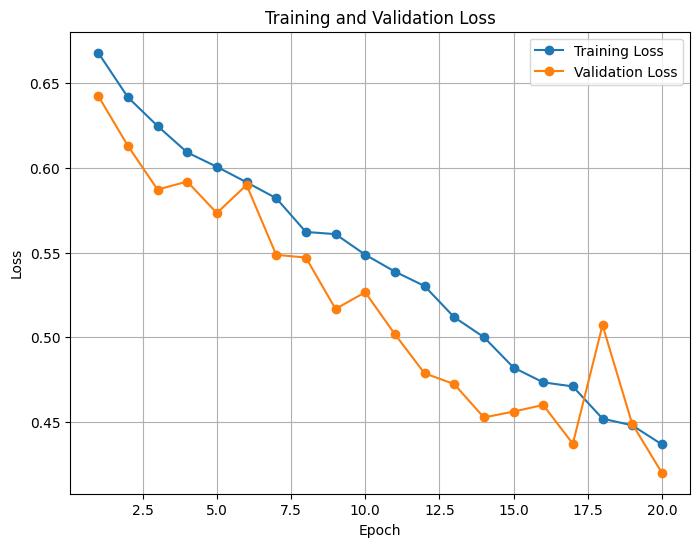

In [14]:
# Plot losses
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')

In [15]:
from google.colab import files

# Download weights-only model
files.download('catsanddogs_classifier.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def predict_image(image_path):
    """
    Predict the label and confidence for a given image.

    Args:
        image_path (str): Path to the image file.

    Returns:
        tuple: Predicted label (str) and confidence (float), or (None, None) if an error occurs.
    """
    try:
        # Open the image and convert it to RGB format
        image = Image.open(image_path).convert('RGB')

        # Apply validation transformations and add a batch dimension
        image_tensor = val_transforms(image).unsqueeze(0).to(device)

        # Disable gradient computation for inference
        with torch.no_grad():
            # Pass the image through the model to get predictions
            output = model(image_tensor)

            # Get the predicted class index
            _, predicted = torch.max(output, 1)

            # Map the predicted index to a label ("Dog" or "Cat")
            label = "Dog" if predicted.item() == 1 else "Cat"

            # Calculate the confidence score for the predicted class
            confidence = torch.softmax(output, dim=1)[0][predicted.item()].item()

            return label, confidence  # Return the label and confidence
    except Exception as e:
        # Print the error message if an exception occurs
        print(f"Error: {e}")
        return None, None  # Return None for both label and confidence

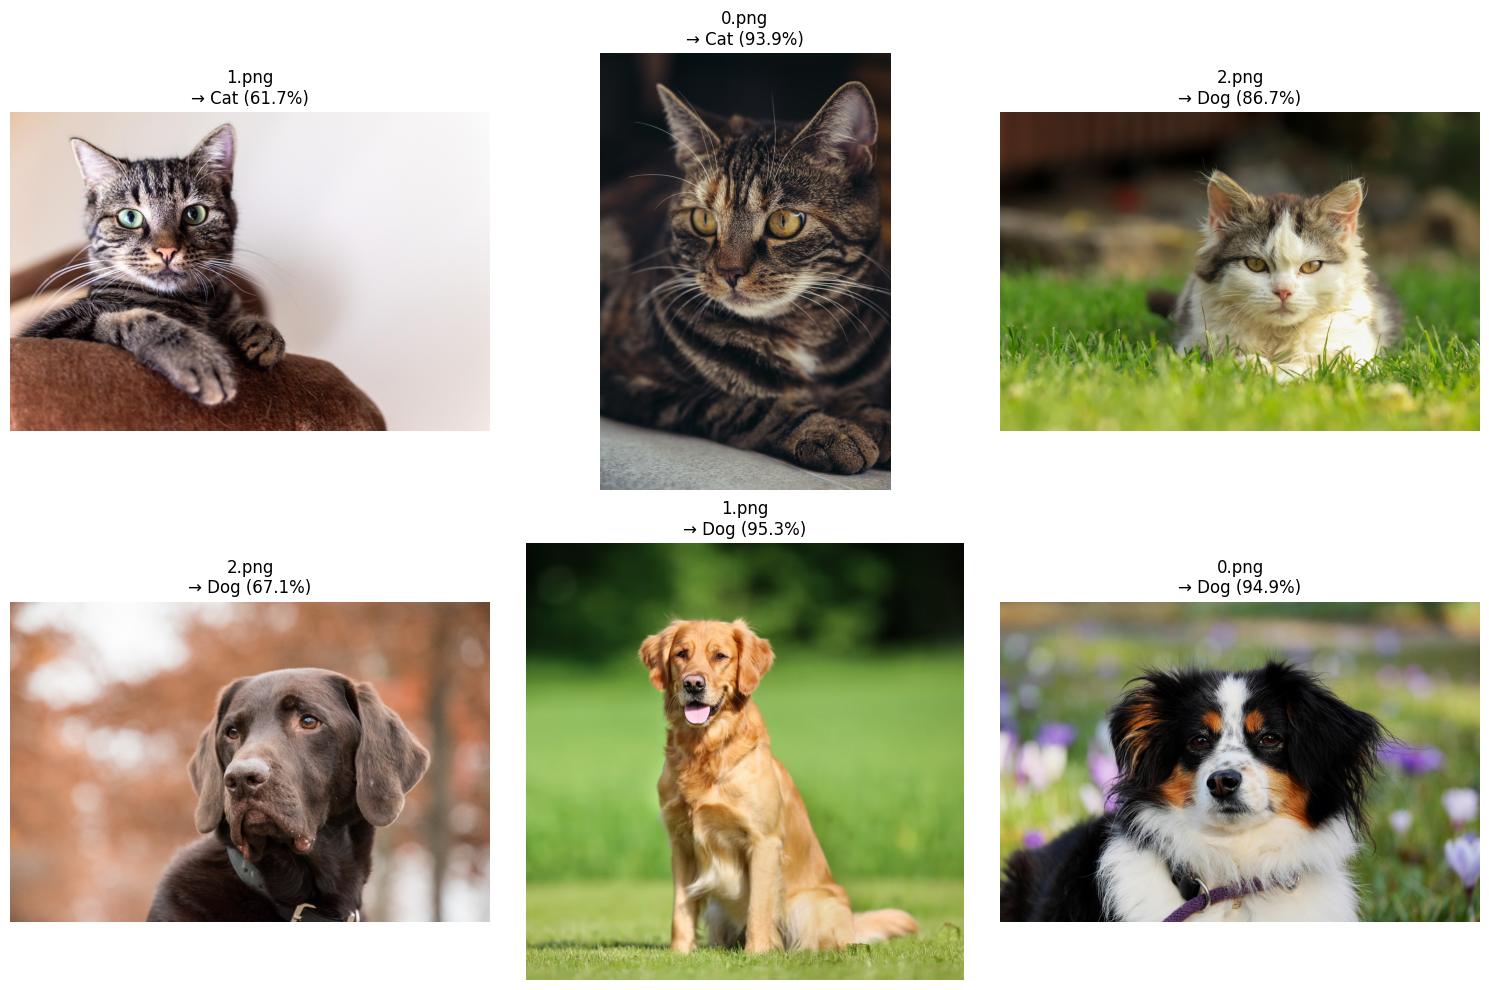

In [ ]:
# Paths to sample image folders
cat_folder = "/content/drive/MyDrive/sample_images/cats"  # Folder containing cat images
dog_folder = "/content/drive/MyDrive/sample_images/dogs"  # Folder containing dog images

# Collect all image paths from the specified folders
image_paths = []
for folder in [cat_folder, dog_folder]:
    for file in os.listdir(folder):  # Iterate through files in the folder
        if file.lower().endswith((".png", ".jpg", ".jpeg")):  # Check for valid image extensions
            image_paths.append(os.path.join(folder, file))  # Add the full path to the list

# Set up the figure for displaying images
plt.figure(figsize=(15, 10))

# Loop through the first 6 images and make predictions
for i, path in enumerate(image_paths[:6], 1):
    label, confidence = predict_image(path)  # Predict the label and confidence for the image
    img = Image.open(path)  # Open the image

    plt.subplot(2, 3, i)  # Create a subplot for the image
    plt.imshow(img)  # Display the image

    # Display the prediction result as the title
    if label is not None:
        plt.title(f"{os.path.basename(path)}\n→ {label} ({confidence*100:.1f}%)")  # Show label and confidence
    else:
        plt.title(f"{os.path.basename(path)}\n→ Prediction failed")  # Handle prediction failure

    plt.axis("off")  # Turn off axis for better visualization

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('cnn_predictions.jpg')  # Save the figure as an image
plt.show()  # Display the figure
